In [1]:
%matplotlib inline
import math, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, operator
from importlib import reload

# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself.

In [2]:
import kmeans; reload(kmeans)
from kmeans import Kmeans

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action.

## Create data

In [3]:
n_clusters = 6
n_samples = 250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In statistical parlance, we're going to simulate 1500 realizations from 6 different bivariate normal distributions (250 each) with random centroids over the range -35, 35.

In [4]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
          for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

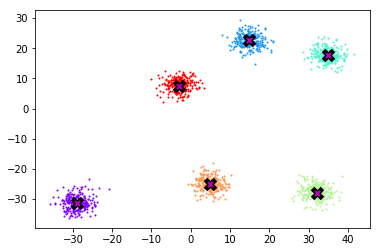

In [5]:
kmeans.plot_data(centroids, data, n_samples)

## K means

The goal of clustering is to identify these clusters, defined by their centroids, given the raw data with no labels. Once these centroids have been identified, each point is labelled as belonging to the centroid it is closest to.

K means clustering is a simple and popular approach of finding appropriate centroids. It does this by taking random centroids, and iteratively moving them to make the clusters as compact as possible.

The algorithm is very simple:
- Select the number of clusters N you want to find
- Guess N random centroids (more on this below)
- While centroids change:
    - Create clusters by assigning each point to the nearest centroid
    - For each cluster, define the new centroid as the centroid of all points assigned to it
    
Typically the algorithm is terminated once the change in centroids is negligible or after a certain number of iterations.

While guessing random centroids is fine in theory, most implementations use the data itself to identify initial cluster points. This speeds up convergence by initializing centroids in the appropriate regime. Typically, inital points are selected amongst the data and tries to pick them to be as far apart as possible.

In [6]:
k = Kmeans(data, n_clusters)

In [7]:
sess = tf.InteractiveSession()

In [8]:
tf.global_variables_initializer().run()
initial_centroids = k.find_initial_centroids(n_clusters).evaz

Instructions for updating:
Use the `axis` argument instead


Inital "random" guesses, based on the data.

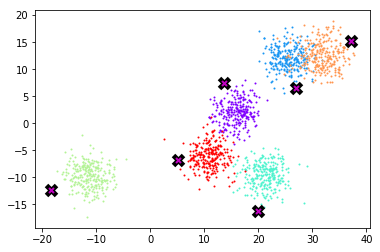

In [9]:
kmeans.plot_data(initial_centroids, data, n_samples)

In [16]:
curr_centroids = tf.Variable(initial_centroids)
nearest_indices = k.assign_to_nearest(curr_centroids)
updated_centroids = k.update_centroids(nearest_indices)
tf.global_variables_initializer().run()

Updated centroids after one iteration.

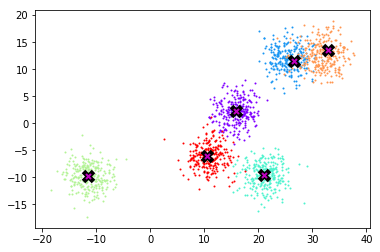

In [12]:
kmeans.plot_data(updated_centroids.eval(), data, n_samples)

In [13]:
curr_centroids.assign(updated_centroids)

<tf.Tensor 'Assign:0' shape=(6, 2) dtype=float32_ref>

In [14]:
with tf.Session().as_default():
    new_centroids = k.run()

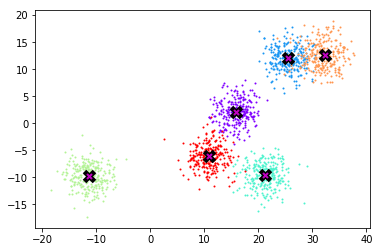

In [15]:
kmeans.plot_data(new_centroids, data, n_samples)

The result are centroids that have minimized the total distance between all points and their centroids; the centroids are "optimal" in this sense.

There are some problems with K-means clustering.
* Number of clusters needs to be known a priori
    * This is an obvious failure of an unsupervised learning algorithm; we want the data to "speak for itself"
    * Difficult to identify in higher dimensions
    
* Naive approach only works if the clusters are the same shape
    * This is because centroid is identified using euclidean distance

## Mean shift

Mean shift clustering is a newer and less well-known approach.

The algorithm is as follows:
* Take each data point X
* For each x in X, find the distance between point x and every other point in X
* Create weights for each point in X by using the Gaussian function of that point's distance to x
    * Gaussian function here is the density function of a Normal distribution of distances with mean 0
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, defined by the weights determined in the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [18]:
def gaussian(d, bw):
    return np.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [19]:
def meanshift(data):
    X = np.copy(data)
    for it in range(5):
        for i, x in enumerate(X):
            dist = np.sqrt(((x - X)**2).sum(1))
            weight = gaussian(dist, 2.5)
            X[i] = (np.expand_dims(weight, 1) * X).sum(0) / weight.sum()
    return X

In [20]:
%time X = meanshift(data)

CPU times: user 884 ms, sys: 0 ns, total: 884 ms
Wall time: 884 ms


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

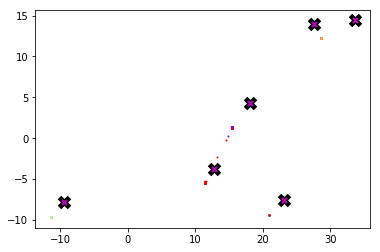

In [21]:
kmeans.plot_data(centroids + 2, X, n_samples)

We should be able to accelerate this algorithm with a GPU.

## PyTorch

GPU-accelerated mean shift implementation in pytorch

In [6]:
import torch_utils; reload(torch_utils)
from torch_utils import *

The advantage of pytorch is that it's very similar to numpy.

In [7]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

Torch does not support broadcasting, therefore Jeremy has replaced the distance subtraction line with a subtraction function from his custom pytorch broadcasting library.

In [32]:
def meanshift(data):
    X = torch.FloatTensor(np.copy(data))
    for it in range(5):
        for i, x in enumerate(X):
            dist = torch.sqrt((sub(x, X)**2).sum(1))
            weight = gaussian(dist, 3)
            num = mul(weight, X).sum(0)
            X[i] = num / weight.sum()
    return X

This implementation actually takes longer.

In [29]:
%time X = meanshift(data).numpy()

CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 1.9 s


All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch.

Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole.

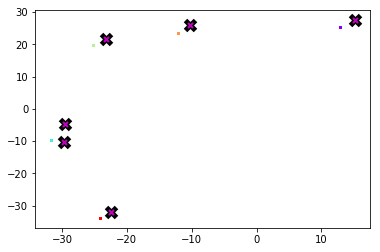

In [31]:
kmeans.plot_data(centroids+2, X, n_samples)

### GPU

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [34]:
def dist_b(a, b):
    return torch.sqrt((sub(a.unsqueeze(0), b.unsqueeze(1))**2).sum(2))

In [54]:
a=torch.rand(2,2)
b=torch.rand(3,2)
dist_b(b, a).squeeze(2)

RuntimeError: dimension out of range (expected to be in range of [-2, 1], but got 2)

In [34]:
def gaussian(d, bw):
    return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [35]:
def sum_sqz(a,axis): return a.sum(axis).squeeze(axis)

In [36]:
def meanshift(data, bs=500):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = sum_sqz(mul(weight, X), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [38]:
%time X = meanshift(data).cpu().numpy()

CPU times: user 48 ms, sys: 36 ms, total: 84 ms
Wall time: 78.9 ms


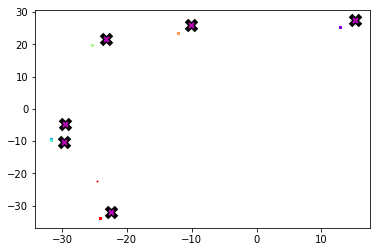

In [39]:
kmeans.plot_data(centroids+2, X, n_samples)

## LSH

TO-DO: Needs notes?

In [40]:
from sklearn.neighbors import LSHForest, KDTree, BallTree

In [41]:
n_clusters=6
n_samples =2500

In [42]:
centroids = np.random.uniform(-35, 35, (n_clusters, 2))
slices = [np.random.multivariate_normal(centroids[i], np.diag([5., 5.]), n_samples)
           for i in range(n_clusters)]
data = np.concatenate(slices).astype(np.float32)

In [43]:
nn = KDTree(data)
nearest = nn.query(data[:10], 3, False); nearest

array([[   0, 1918,  905],
       [   1,  102, 1294],
       [   2, 2345, 1397],
       [   3, 2383,  943],
       [   4,   15, 1886],
       [   5, 2243,  161],
       [   6, 2085, 1853],
       [   7, 2222, 2177],
       [   8,  324, 2008],
       [   9,  396, 1659]])

In [44]:
nn = BallTree(data)
nearest = nn.query(data[:10], 3, False); nearest

array([[   0, 1918,  905],
       [   1,  102, 1294],
       [   2, 2345, 1397],
       [   3, 2383,  943],
       [   4,   15, 1886],
       [   5, 2243,  161],
       [   6, 2085, 1853],
       [   7, 2222, 2177],
       [   8,  324, 2008],
       [   9,  396, 1659]])

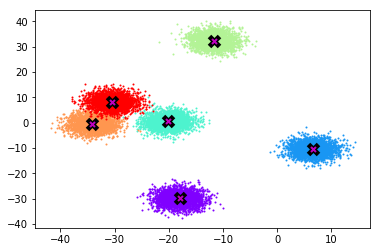

In [45]:
kmeans.plot_data(centroids, data, n_samples)

In [46]:
def index_b(a,idxs):
    ir, ic = idxs.size()
    ar, ac = a.size()
    return a[idxs.view(ir*ic)].view(ir,ic,ac)

In [47]:
a = FT([[1,2],[3.,4],[5,6]])
b = torch.LongTensor([[0,1], [1,2]])
exp = FT([[[1,2], [3,4.]], [[3,4], [5,6]]])
assert(torch.equal(index_b(a,b), exp))

In [48]:
def dist_b_n(a,b,pts):
    dists = sub(pts,b.unsqueeze(1))**2
    return torch.sqrt(dists.sum(2))

In [49]:
def meanshift(data, bs=512):
    n = len(data)
    X = torch.FloatTensor(np.copy(data)).cuda()
    for it in range(5):
        d = X.cpu().numpy()
        nn = BallTree(d)
        for i in range(0,n,bs):
            s = slice(i,min(n,i+bs))
            nearest = torch.LongTensor(nn.query(d[s], 50, False)).cuda()
            pts = index_b(X, nearest)
            weight = gaussian(dist_b_n(X, X[s], pts), 2)
            num = sum_sqz(mul(weight, pts), 1)
            X[s] = div(num, sum_sqz(weight, 1))
    return X

In [50]:
%time data = meanshift(data).cpu().numpy()

CPU times: user 1.45 s, sys: 16 ms, total: 1.46 s
Wall time: 1.35 s


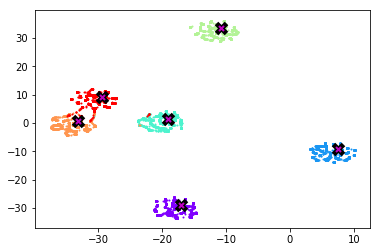

In [51]:
kmeans.plot_data(centroids+1, data, n_samples)